In [1]:
import matplotlib.pyplot as plt 
import json 
import numpy as np 
import pandas as pd 
import seaborn as sns

from pathlib import Path 
from matplotlib.ticker import FuncFormatter

In [2]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

In [3]:
def load_problem(problem, results):
    df = pd.DataFrame()

    # if results are already compiled, just load them
    if (results / "compiled" / f"{problem}.csv").exists():
        df = pd.read_csv(results / "compiled" / f"{problem}.csv")
        return df
    
    # else compile results into dataframe 
    for csv in results.rglob(f"{problem}*.csv"):

        dir = csv.parent 

        config = dir / "config.json"

        if not config.exists():
            continue
        
        # get checkpoint file 
        chkpts = list(dir.glob("*full.pt"))
        if len(chkpts) == 0:
            chkpt = ''
        else: 
            chkpt = chkpts[0]
        

        # load config
        # contains run info 
        with open(config, "r") as f:
            config = json.load(f)

        
        # write config to df 
        cur_df = pd.read_csv(csv)
        
        model_name = config['model_name']

        if problem == 'wave': 
            if not '1000_domain' in model_name:
                continue 
        
        cur_df['problem'] = problem
        cur_df['distribution_k'] = config['distribution_k']
        cur_df['distribution_c'] = config['distribution_c']
        cur_df['sampling_strategy'] = config['sampling_strategy']
        cur_df['scoring_strategy'] = config['scoring_strategy']
        cur_df['sign'] = config['scoring_sign']
        cur_df['seed'] = model_name[model_name.rfind("_")+1:]
        cur_df['n_iter_pretrain'] = model_name[model_name.find('adam')+5:model_name.find('_', model_name.find('adam')+6)]
        cur_df['model_name'] = model_name
        cur_df['n_samples'] = config['n_samples']
        cur_df['training_strategy'] = config['training_strategy']
        cur_df['checkpoint'] = chkpt
        
        # append run
        df = pd.concat([df, cur_df])

    # drop duplicate runs 
    # note: due to seeding all runs with the same hyperparameters also have same results
    df = df.drop_duplicates()
    # pinnfluence.utils.callbacks.EvalMetricCallback considers each time data is resampled 
    # as epoch 0 internally 
    # results on test data are however equivalent to last epoch before resampling 
    # so we can drop it to avoid duplicates in data and irregularities regarding the epoch number
    df = df.loc[df['epoch'] != 0]

    # rename columns etc for readability
    df.rename(
        columns = {
            'train_loss': 'Train Loss',
            'valid_loss': 'Validation Loss',
            'test_loss': "Test Loss",
            'l2_relative_error': 'L2 Relative Error',
            'mse': 'Mean Squared Error',
            'epoch': "Iteration",
            "scoring_strategy": "Strategy"
            },
        inplace = True
    )
    df = df.loc[(df['sign'] == 'abs') & (df['seed'].astype(int) <= 10)]
    df.drop_duplicates(subset=['Strategy', 'Iteration', 'seed', 'n_iter_pretrain', 'n_samples', 'distribution_k', 'distribution_c', 'sampling_strategy', 'model_name'], inplace=True, keep='first')


    df['Strategy'] = df['Strategy'].replace(
        {
            "IF": "PINNfluence (ours)", # old name
            "PINNfluence": "PINNfluence (ours)", # new name
            "random": "Random",
            "grad_dot": "Grad-Dot",
            "RAR": "RAR",
            "steepest_prediction_gradient": "$||\\nabla_{x} u||_2$",
            "steepest_loss_gradient": "$||\\nabla_{\\theta} \\mathcal{L}||_2$",
        }
    )

    order_dict = {
        'PINNfluence (ours)': 0,
        'RAR': 1, 
        'Random': 2,
        'Grad-Dot': 3,
        '$||\\nabla_{x} u||_2$': 4,
        '$||\\nabla_{\\theta} \\mathcal{L}||_2$': 5
    }

    df = df.sort_values(by='Strategy', key=lambda x: x.map(order_dict))

    # save compiled results
    if not (results / "compiled").exists():
        (results / "compiled").mkdir()
    df.to_csv(results / "compiled" / f"{problem}.csv", index=False)

    return df

In [4]:
# check if all runs are present
results = Path("../../results/full/incremental_replace")
for problem in ['diffusion', 'burgers', 'allen_cahn', 'wave']:
    df = load_problem(problem, results)

    print(problem)
    sub_df = df.loc[
        (df['sampling_strategy'] == 'distribution') & 
        (df['sign'] == 'abs') & 
        (df['Iteration'] == 100000) & 
        (df['n_iter_pretrain'] == 0) & 
        (df['distribution_k'] == 1) & 
        (df['distribution_c'] == 1) 
    ]

    for strat in sub_df['Strategy'].unique():
        print(strat)
        print(sorted(sub_df.loc[sub_df['Strategy'] == strat, 'seed'].unique()))


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


diffusion
PINNfluence (ours)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
RAR
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Random
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Grad-Dot
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{x} u||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{\theta} \mathcal{L}||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


burgers
PINNfluence (ours)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
RAR
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Random
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Grad-Dot
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{x} u||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{\theta} \mathcal{L}||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


allen_cahn
PINNfluence (ours)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
RAR
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Random
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Grad-Dot
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{x} u||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{\theta} \mathcal{L}||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


wave
PINNfluence (ours)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
RAR
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Random
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Grad-Dot
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{x} u||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
$||\nabla_{\theta} \mathcal{L}||_2$
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [5]:
# format x axis as thousands
def format_iterations(x, pos):
    return f'{int(x / 1000)}K'  

def plot(df, c, k, distribution, n_iter_pretrain, n_samples, window=100):
    # Get the full dataset without downsampling
    sub_df = df.loc[
        (df['distribution_c'] == c) &
        (df['distribution_k'] == k) &
        (df['sampling_strategy'] == distribution) &
        (df['sign'] == 'abs') &
        (df['n_iter_pretrain'] == n_iter_pretrain) &
        (df['n_samples'] == n_samples) & 
        (df['Iteration'] != 50_001) # exclude first iteration of continued runs 
    ]
    
    # Filter out alignment strategies
    # NOTE: this was an experiment not included in the paper
    sub_df = sub_df.loc[
        ~sub_df['Strategy'].str.startswith('alignment')
    ]

    colors = {
        "random": "black",
        "Random": "black",
        "RAR": "green",
        "IF": "blue",
        "PINNfluence (ours)": "blue",
        "grad_dot": "red",
        "Grad-Dot": "red",
        "steepest_prediction_gradient": "brown",
        "$||\\nabla_{x} u||_2$": "brown",
        "steepest_loss_gradient": "purple",
        "$||\\nabla_{\\theta} \\mathcal{L}||_2$": "purple",
    }

    # Define markers for each strategy
    markers = {
        'PINNfluence (ours)': 'D',
        'RAR': 'p',
        'Random': '*',
        'Grad-Dot': '^',
        '$||\\nabla_{x} u||_2$': 'o',
        '$||\\nabla_{\\theta} \\mathcal{L}||_2$': 's',
    }
    
    # Set the 'Strategy' column as a categorical type with the desired order
    strategy_order = list(markers.keys())
    sub_df['Strategy'] = pd.Categorical(sub_df['Strategy'], categories=strategy_order, ordered=True)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Initialize lists to collect handles and labels for the legend
    handles = []
    labels = []
    
    # Iterate over strategies in the specified order
    for name in strategy_order:
        strategy_group = sub_df[sub_df['Strategy'] == name]
        if strategy_group.empty:
            continue

        # Group by iteration to handle the 10 seeds
        agg_data = strategy_group.groupby('Iteration')['L2 Relative Error'].agg(['mean', 'std']).reset_index()
        
        # Sort by iteration for proper plotting
        agg_data = agg_data.sort_values('Iteration')
        
        # Calculate rolling statistics
        rolling_data = agg_data.set_index('Iteration')
        rolling_mean = rolling_data['mean'].rolling(window=window, min_periods=1).mean()
        
        # Calculate log-scale confidence intervals
        log_std = rolling_data['std'].div(rolling_data['mean']).rolling(window=window, min_periods=1).mean()
        factor = np.exp(log_std)  # Multiplicative factor for log scale
        lower_bound = rolling_mean / factor
        upper_bound = rolling_mean * factor
        
        # Get the marker for the current strategy
        marker = markers.get(name, 'o')
        
        # Calculate the positions where markers should appear
        marker_positions = rolling_mean.index % 10000 == 0
        marker_indices = np.where(marker_positions)[0]
        
        # Plot the rolling mean line with markers
        line, = ax.plot(rolling_mean.index, rolling_mean.values, label=name,
                        color=colors[name] if name in colors else None,
                        marker=marker,
                        markevery=marker_indices,
                        markersize=8)
        
        # Add the line handle and label to the lists
        handles.append(line)
        labels.append(name)
        
        # Add confidence interval
        ax.fill_between(rolling_mean.index, lower_bound, upper_bound, 
                        color=colors[name] if name in colors else None,
                        alpha=0.2)
    
    # Style the plot
    ax.set_yscale('log')
    ax.set_ylabel('$L^2$ Relative Error')
    ax.set_xlabel('Iteration')

    # Set the legend with the handles and labels in the desired order
    # ax.legend(handles=handles, labels=labels, loc='upper right')

    # Style the ticks
    ax.tick_params(axis='both', which='major')
    ax.xaxis.set_major_formatter(FuncFormatter(format_iterations))

    fig.tight_layout()

    return fig, ax

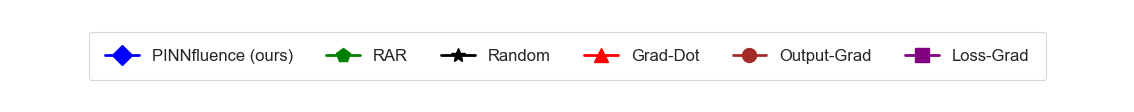

In [6]:
import matplotlib.lines as mlines

def create_standalone_legend():
    # Define colors for strategies
    colors = {
        "random": "black",
        "Random": "black",
        "RAR": "green",
        "IF": "blue",
        "PINNfluence (ours)": "blue",
        "grad_dot": "red",
        "Grad-Dot": "red",
        "steepest_prediction_gradient": "brown",
        "$||\\nabla_{x} u||_2$": "brown",
        "Output-Grad": "brown",
        "steepest_loss_gradient": "purple",
        "$||\\nabla_{\\theta} \\mathcal{L}||_2$": "purple",
        "Loss-Grad": "purple",
    }

    # Define markers for each strategy
    markers = {
        'PINNfluence (ours)': 'D',
        'RAR': 'p',
        'Random': '*',
        'Grad-Dot': '^',
        'Output-Grad': 'o',
        'Loss-Grad': 's',
    }
    
    # Define the strategy order (same as in your plot function)
    strategy_order = list(markers.keys())
    
    # Create a figure for the legend only
    fig, ax = plt.subplots(figsize=(12, 1.5))
    
    # Create legend handles
    handles = []
    labels = []
    
    # Create a line for each strategy
    for i, name in enumerate(strategy_order):
        if name in colors:
            line = mlines.Line2D([], [], color=colors[name], marker=markers[name], 
                                markersize=10, label=name, linewidth=2)
            handles.append(line)
            labels.append(name)
    
    # Create the legend
    legend = ax.legend(handles=handles, labels=labels, 
                      loc='center', ncol=len(handles), 
                      frameon=True, fontsize=12, 
                      handlelength=2, borderpad=1,
                      columnspacing=2)
    
    # Remove axis elements
    ax.set_frame_on(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    fig.tight_layout()
    
    return fig, ax

fig, ax = create_standalone_legend()
fig.savefig("./figures/legend_horizontal_seperate_plots.pdf", bbox_inches='tight')

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: diffusion, n_samples: 30, layers: 3_x_32, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = sub_df.loc[sub_df.groupby(['Strategy', 'seed'])['Validation Loss'].idxmin().values]
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: allen_cahn, n_samples: 1000, layers: 3_x_64, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = sub_df.loc[sub_df.groupby(['Strategy', 'seed'])['Validation Loss'].idxmin().values]
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: burgers, n_samples: 1000, layers: 3_x_32, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = sub_df.loc[sub_df.groupby(['Strategy', 'seed'])['Validation Loss'].idxmin().values]
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: wave, n_samples: 1000, layers: 5_x_100, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)
        PINNfluence (ours) & 0.06±0.02  & 3.0±0.3  & 1.9±0.8  & 8.1±7.8  \\
        RAR & 0.06±0.02  & 2.8±0.4  & 2.0±1.4  & 11.1±8.8  \\
        Grad-Dot & 0.05±0.01  & 4.5±0.9  & 2.0±0.7  & 17.7±13.1  \\
        $||\nabla_{x} u||_2$ & 0.05±0.01  & 13.0±5.0  & 3.1±1.2  & 46.1±5.6  \\
        $||\nabla_{\theta} \mathcal{L}||_2$ & 0.06±0.02  & 4.5±0.6  & 1.5±0.7  & 16.0±9.6  \\
        Random & 0.05±0.02  & 5.3±1.7  & 9.6±9.9  & 44.3±1.7  \\
        \midrule\n        PINNfluence (ours) & $2.7 \pm 0.8 \cdot 10^{-5}$  & $3.3 \pm 0.6 \cdot 10^{-5}$  & $6.2 \pm 0.8 \

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_24453/4254046325.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  final_df = sub_df.loc[sub_df.groupby(['Strategy', 'seed'])['Validation Loss'].idxmin().values]


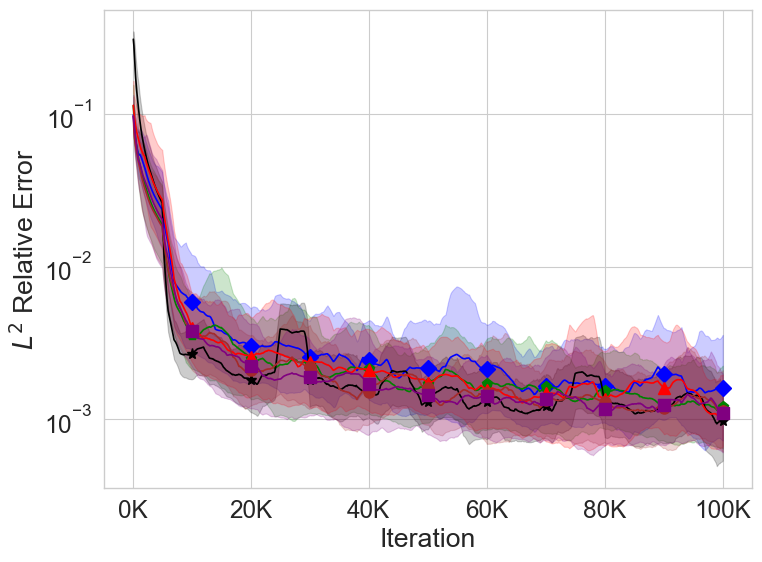

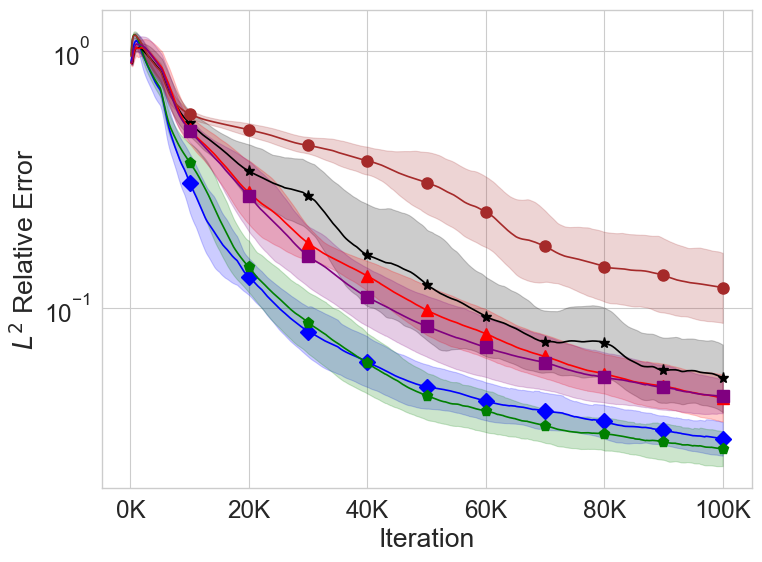

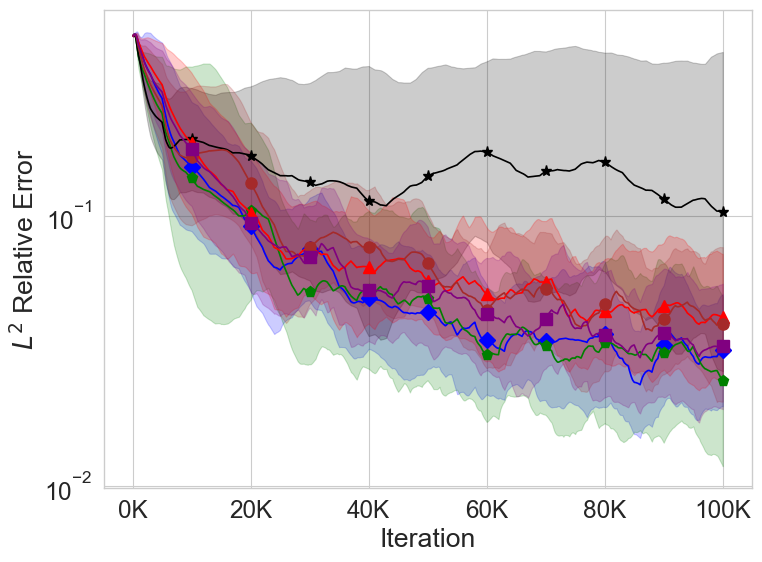

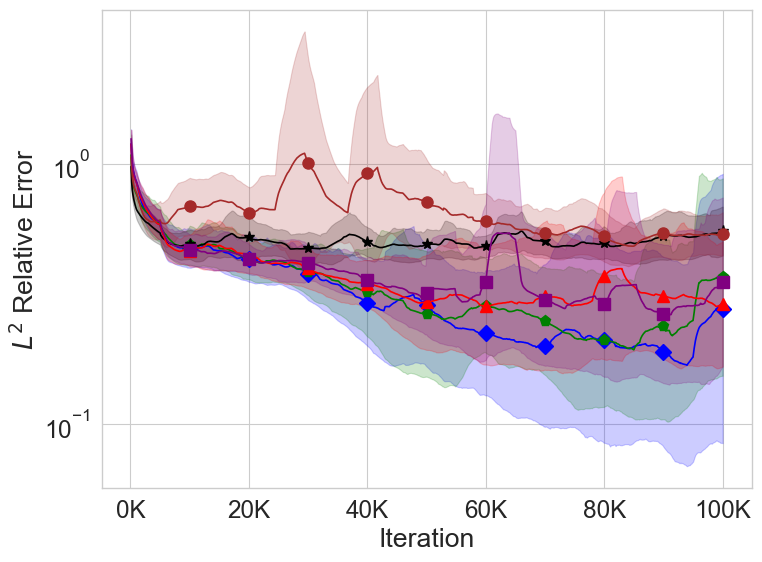

In [7]:
# Initialize a nested dictionary to store results
results_table = {}

k = 1
c = 1
distribution = 'distribution'
n_iter_pretrain = 0

fig_dir = Path("./figures")
if not fig_dir.exists():
    fig_dir.mkdir()

problems=[
    ('diffusion', 30, '3_x_32'),
    ('allen_cahn', 1000, '3_x_64'),
    ('burgers', 1000, '3_x_32'), 
    ('wave', 1000, '5_x_100'),
]

# Define the methods you want to include in the table
methods = [
    'PINNfluence (ours)',
    'RAR',
    'Grad-Dot',
    '$||\\nabla_{x} u||_2$',
    '$||\\nabla_{\\theta} \\mathcal{L}||_2$',
    'Random',
]

# Initialize the results dictionary with methods as keys
for method in methods:
    results_table[method] = {}

for problem, n_samples, layers in problems:
    df = load_problem(problem, results)
    df = df.loc[df['seed'] <= 10]
    df = df.loc[df['Iteration'] <= 100_000]
    
     # Filter the DataFrame as in the plot function
    sub_df = df.loc[
        (df['distribution_c'] == c) &
        (df['distribution_k'] == k) &
        (df['sampling_strategy'] == distribution) &
        (df['sign'] == 'abs') &
        (df['n_iter_pretrain'] == n_iter_pretrain) &
        (df['n_samples'] == n_samples) & 
        (df['model_name'].str.contains(layers)) & 
        ((df['Iteration'] % 2) == 0) # drop "epoch 1" iterations (only multiples of 100 are included)
    ]
    
    # Exclude alignment strategies
    sub_df = sub_df.loc[
        ~sub_df['Strategy'].str.startswith('alignment')
    ]

    sanity_check = sub_df.loc[sub_df['Iteration'] == sub_df['Iteration'].max()].groupby('Strategy')['seed'].count()
    
    print(f"Problem: {problem}, n_samples: {n_samples}, layers: {layers}, c: {c}, k: {k}, distribution: {distribution}, n_iter_pretrain: {n_iter_pretrain}")
    print(sub_df.loc[sub_df['Iteration'] == sub_df['Iteration'].max()].groupby('Strategy')['seed'].count())
    print(sorted(sub_df['seed'].unique()))
    print(sub_df['seed'].unique().shape)
        
    fig, ax = plot(sub_df.loc[sub_df['model_name'].str.contains(layers)], c, k, distribution, n_iter_pretrain, n_samples, window=50)
    fig.show()
    fig.savefig(fig_dir / f"{problem}_c{c}_k{k}_{distribution}_n{n_samples}_{layers}.pdf")


    # Set the 'Strategy' column as a categorical type with the desired order
    strategy_order = methods
    sub_df['Strategy'] = pd.Categorical(sub_df['Strategy'], categories=strategy_order, ordered=True)
    
    # Get data from the final iteration
    max_iteration = sub_df['Iteration'].max()
    final_df = sub_df.loc[sub_df.groupby(['Strategy', 'seed'])['Validation Loss'].idxmin().values]
    
    # Group by 'Strategy' and compute geometric mean and standard deviation
    for strategy in methods:
        group = final_df[final_df['Strategy'] == strategy]
        if group.empty:
            # If there's no data for this strategy and problem, you may want to handle it
            results_table[strategy][problem] = {'L2 Error': 'N/A', 'Loss': 'N/A'}
            continue
        
        l2_errors = group['L2 Relative Error'].values * 100
        losses = group['Test Loss'].values  # Assuming you have a 'Loss' column
        
        # Ensure all values are positive for geometric mean
        if np.any(l2_errors <= 0) or np.any(losses <= 0):
            results_table[strategy][problem] = {'L2 Error': 'N/A', 'Loss': 'N/A'}
            continue
        
        # Compute geometric mean and standard deviation for L2 Error
        l2_gmean = np.mean(l2_errors)
        l2_std = np.std(l2_errors, ddof=1)
        
        # Compute geometric mean and standard deviation for Loss
        loss_gmean = np.mean(losses)
        loss_std = np.std(losses, ddof=1)
        
        # Format the results with three decimal places
        if problem == 'diffusion':
            l2_result = f"{l2_gmean:.2f}±{l2_std:.2f}"
            loss_result = f"{loss_gmean:.1e}±{loss_std:.1e}"
        else:
            l2_result = f"{l2_gmean:.1f}±{l2_std:.1f}"
        loss_exponent = np.floor(np.log10(loss_gmean))
        loss_mantissa = loss_gmean / (10 ** loss_exponent)
        loss_std_mantissa = loss_std / (10 ** loss_exponent)
        loss_result = f"${loss_mantissa:.1f} \pm {loss_std_mantissa:.1f} \cdot 10^{{{loss_exponent:.0f}}}$"
        
        # Store the results
        results_table[strategy][problem] = {'L2 Error': l2_result, 'Loss': loss_result}

# Now, generate the LaTeX table
latex_table = ""

# Fill in the table rows
for method in methods:
    row = f"        {method}"
    for problem, _, _ in problems:
        l2_error = results_table[method][problem]['L2 Error']
        loss = 0 
        row += f" & {l2_error} "
    row += r" \\"
    latex_table += row + "\n"

latex_table += r"        \midrule\n"

for method in methods:
    row = f"        {method}"
    for problem, _, _ in problems:
        loss = results_table[method][problem]['Loss']
        row += f" & {loss} "
    row += r" \\"
    latex_table += row + "\n"

latex_table += r"""        \bottomrule
    \end{tabular}
\end{table}
"""

print(latex_table)

In [8]:
def plot_combined_problems(problems_data, selected_methods, window=100, metric='L2 Relative Error'):
    """
    Create a single plot comparing selected methods across multiple problems,
    showing performance relative to Random sampling.
    Colors are assigned by problem and line styles by method.
    """
    # Create figure with a single plot
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Define colors for different problems (using more distinguishable colors)
    problem_colors = {
        'diffusion': "#1F77B4",  # Black
        'allen_cahn': "#FF7F0E",  # Blue
        'burgers': "#2CA02C",    # Green
        'wave': "#D62728"        # Red-orange
    }
    
    # Define line styles for different methods
    method_styles = {
        'PINNfluence (ours)': '-',
        'RAR': '--'  # Changed from dotted to dashed for better visibility
    }
    
    handles = []
    labels = []
    
    # Process each problem
    for problem_name, df in problems_data.items():
        # Make sure Random is in the dataframe
        if 'Random' not in df['Strategy'].unique():
            print(f"Warning: 'Random' strategy not found in {problem_name} data")
            continue
            
        # Get only the methods we want to plot (excluding Random)
        plot_methods = [m for m in selected_methods if m != 'Random']
        
        # For each method, calculate relative performance against Random
        for method in plot_methods:
            # Group and aggregate data for Random strategy
            random_data = df[df['Strategy'] == 'Random'].copy()
            if random_data.empty:
                continue
                
            random_agg = random_data.groupby('Iteration')[metric].agg(['mean']).reset_index()
            random_agg.set_index('Iteration', inplace=True)
            
            # Group and aggregate data for the current method
            method_data = df[df['Strategy'] == method].copy()
            if method_data.empty:
                continue
                
            method_agg = method_data.groupby('Iteration')[metric].agg(['mean', 'std']).reset_index()
            method_agg.set_index('Iteration', inplace=True)
            
            # Make sure indices match
            common_index = method_agg.index.intersection(random_agg.index)
            if len(common_index) == 0:
                continue
                
            method_agg = method_agg.loc[common_index]
            random_agg = random_agg.loc[common_index]
            
            # Calculate error ratio (method error / random error)
            ratio = method_agg['mean'] / random_agg['mean']
            
            # Calculate rolling average of the ratio
            rolling_ratio = ratio.rolling(window=window, min_periods=1).mean()
            
            # Calculate confidence interval
            ratio_std = method_agg['std']
            ratio_std = ratio_std.rolling(window=window, min_periods=1).mean()
            lower_bound = rolling_ratio - ratio_std
            upper_bound = rolling_ratio + ratio_std
            
            # Plot the rolling ratio with improved visibility
            label = f"{method} ({problem_name})"
            line, = ax.plot(
                rolling_ratio.index, 
                rolling_ratio.values,
                label=label,
                color=problem_colors[problem_name],
                linestyle=method_styles[method],
                linewidth=2.5,                               # Slightly thinner lines
                markerfacecolor='white',                     # White fill for markers
                markeredgewidth=1.5                          # Bold marker edges
            )
            
            handles.append(line)
            labels.append(label)
            
            # Add light shading for confidence intervals
            ax.fill_between(
                rolling_ratio.index, 
                lower_bound, 
                upper_bound,
                color=problem_colors[problem_name],
                alpha=0.1
            )

    # Add a horizontal line at y=1 (equal to random performance)
    ax.axhline(y=1, color='gray', linestyle=':', alpha=0.8, linewidth=1.5)
    
    # Style the plot with improved formatting
    ax.set_ylabel('Error Ratio (Method / Random)', rotation=270, labelpad=14)#, fontsize=12)
    ax.set_xlabel('Iteration')#, fontsize=12)
    
    # Set axis limits
    ax.set_ylim(0, 3)  # Adjusted based on your data range
    ax.set_xlim(0, 100000)  # Set to match your iteration range

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Style the ticks
    ax.tick_params(axis='both', which='major')#, labelsize=10)
    ax.xaxis.set_major_formatter(FuncFormatter(format_iterations))
    
    # Format the spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Adjust layout with more padding
    plt.tight_layout(pad=2.0)
    
    return fig, ax

# Example usage:
def create_combined_plot(results):
    # Define problems
    problems = [
        ('diffusion', 30, '3_x_32'),
        ('allen_cahn', 1000, '3_x_64'),
        ('burgers', 1000, '3_x_32'), 
        ('wave', 1000, '5_x_100'),
    ]
    
    # Selected methods to plot (including Random as reference)
    selected_methods = ['PINNfluence (ours)', 'RAR', 'Random']
    
    # Constants for filtering
    c = 1
    k = 1
    distribution = 'distribution'
    n_iter_pretrain = 0
    
    # Dictionary to store dataframes for each problem
    problems_data = {}
    
    for problem, n_samples, layers in problems:
        # Assume load_problem is defined elsewhere and returns a dataframe
        df = load_problem(problem, results)
        df = df.loc[df['seed'] <= 10]
        df = df.loc[df['Iteration'] <= 100_000]
        
        # Filter the DataFrame as in the plot function
        sub_df = df.loc[
            (df['distribution_c'] == c) &
            (df['distribution_k'] == k) &
            (df['sampling_strategy'] == distribution) &
            (df['sign'] == 'abs') &
            (df['n_iter_pretrain'] == n_iter_pretrain) &
            (df['n_samples'] == n_samples) & 
            (df['model_name'].str.contains(layers)) 
        ]
        
        # Exclude alignment strategies
        sub_df = sub_df.loc[
            ~sub_df['Strategy'].str.startswith('alignment')
        ]
        
        # sanity check
        print(f"Problem: {problem}, n_samples: {n_samples}, layers: {layers}, c: {c}, k: {k}, distribution: {distribution}, n_iter_pretrain: {n_iter_pretrain}")
        print(sub_df.loc[sub_df['Iteration'] == sub_df['Iteration'].max()].groupby('Strategy')['seed'].count())
        print(sorted(sub_df['seed'].unique()))
        print(sub_df['seed'].unique().shape)
        
        # Store filtered dataframe
        problems_data[problem] = sub_df
    
    # Create the combined plot
    fig, ax = plot_combined_problems(problems_data, selected_methods, window=50)
    
    # Save the figure
    fig_dir = Path("./figures")
    if not fig_dir.exists():
        fig_dir.mkdir()
    
    fig.savefig(fig_dir / f"replace_relative_to_random_comparison.pdf", bbox_inches='tight', dpi=300)
    
    return fig, ax

In [9]:
sns.set_context("paper", font_scale=1.5)
plt.rcParams.update({'font.size': 24})

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: diffusion, n_samples: 30, layers: 3_x_32, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: allen_cahn, n_samples: 1000, layers: 3_x_64, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: burgers, n_samples: 1000, layers: 3_x_32, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Problem: wave, n_samples: 1000, layers: 5_x_100, c: 1, k: 1, distribution: distribution, n_iter_pretrain: 0
Strategy
$||\nabla_{\theta} \mathcal{L}||_2$    10
$||\nabla_{x} u||_2$                   10
Grad-Dot                               10
PINNfluence (ours)                     10
RAR                                    10
Random                                 10
Name: seed, dtype: int64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(10,)


(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Iteration', ylabel='Error Ratio (Method / Random)'>)

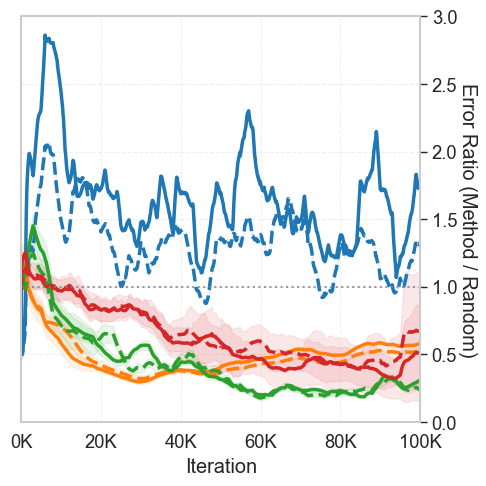

In [10]:
create_combined_plot(results)

In [11]:
def create_separate_legend(problem_colors, method_styles):
    """
    Create a separate horizontal legend figure that can be used with multiple plots.
    """
    from matplotlib.lines import Line2D
    
    # Create a new figure for the legend only
    legend_fig = plt.figure(figsize=(10, 1.5))
    legend_ax = legend_fig.add_subplot(111)
    
    # Hide axes
    legend_ax.axis('off')
    
    # Method legend elements (line styles)
    method_legend_elements = []
    for method, style in method_styles.items():
        method_legend_elements.append(
            Line2D([0], [0], color='black', linestyle=style, 
                   label=method, linewidth=2)
        )
    
    # Problem legend elements (colors)
    problem_legend_elements = []
    for problem, color in problem_colors.items():
        problem_legend_elements.append(
            Line2D([0], [0], color=color, label=problem.replace('_', ' ').title(), linewidth=2)
        )
    
    # Combine all legend elements
    all_elements = method_legend_elements + problem_legend_elements
    all_labels = [e.get_label() for e in all_elements]
    
    # Create a horizontal legend
    legend = legend_ax.legend(
        handles=all_elements,
        labels=all_labels,
        loc='center',
        ncol=len(all_elements),  # All elements in one row
        frameon=True,
        framealpha=1,
        edgecolor='gray',
        mode='expand',  # Expand horizontally
        bbox_to_anchor=(0, 0, 1, 1)  # Use the entire figure space
    )
    
    legend_fig.tight_layout(pad=0.4)
    
    return legend_fig

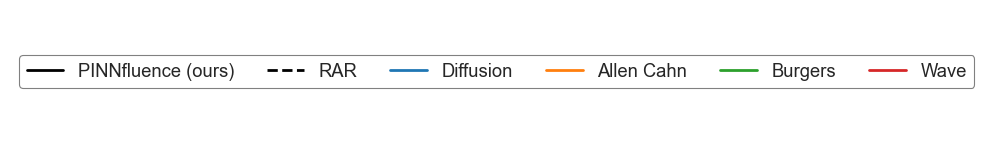

In [12]:
create_separate_legend(
    problem_colors = {
        'diffusion': "#1F77B4",  # Black
        'allen_cahn': "#FF7F0E",  # Blue
        "burgers": "#2CA02C",    # Green
        'wave': "#D62728"        # Red-orange
    },
    
    # Define line styles for different methods
    method_styles = {
        'PINNfluence (ours)': '-',
        'RAR': '--'
    }
).savefig("./figures/legend_horizontal_combined_plots.pdf", bbox_inches='tight', dpi=300)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


burgers
Compiling model...
'compile' took 0.390288 s

Best epoch: 100000
Compiling model...
'compile' took 0.000051 s

Best epoch: 100000
Compiling model...
'compile' took 0.000056 s

Best epoch: 100000
Compiling model...
'compile' took 0.000046 s

Best epoch: 100000
Compiling model...
'compile' took 0.000040 s

Best epoch: 100000
Compiling model...
'compile' took 0.000044 s

Best epoch: 100000
Compiling model...
'compile' took 0.000040 s

Best epoch: 100000
Compiling model...
'compile' took 0.000041 s

Best epoch: 100000
Compiling model...
'compile' took 0.000042 s

Best epoch: 100000
Compiling model...
'compile' took 0.000041 s

Best epoch: 100000
Compiling model...
'compile' took 0.000037 s

Best epoch: 100000
Compiling model...
'compile' took 0.000042 s

Best epoch: 100000
Compiling model...
'compile' took 0.000043 s

Best epoch: 100000
Compiling model...
'compile' took 0.000038 s

Best epoch: 100000
Compiling model...
'compile' took 0.000042 s

Best epoch: 100000
Compiling model..

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1522137904.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


diffusion
Compiling model...
'compile' took 0.000047 s

Best epoch: 100000
Compiling model...
'compile' took 0.000039 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000034 s

Best epoch: 100000
Compiling model...
'compile' took 0.000038 s

Best epoch: 100000
Compiling model...
'compile' took 0.000038 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000037 s

Best epoch: 100000
Compiling model...
'compile' took 0.000034 s

Best epoch: 100000
Compiling model...
'compile' took 0.000038 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1522137904.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


wave
Compiling model...
'compile' took 0.000049 s



/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Best epoch: 100000
Compiling model...
'compile' took 0.000051 s

Best epoch: 100000
Compiling model...
'compile' took 0.000045 s

Best epoch: 100000
Compiling model...
'compile' took 0.000046 s

Best epoch: 100000
Compiling model...
'compile' took 0.000105 s

Best epoch: 100000
Compiling model...
'compile' took 0.000056 s

Best epoch: 100000
Compiling model...
'compile' took 0.000051 s

Best epoch: 100000
Compiling model...
'compile' took 0.000085 s

Best epoch: 100000
Compiling model...
'compile' took 0.000046 s

Best epoch: 100000
Compiling model...
'compile' took 0.000049 s

Best epoch: 100000
Compiling model...
'compile' took 0.000087 s

Best epoch: 100000
Compiling model...
'compile' took 0.000067 s

Best epoch: 100000
Compiling model...
'compile' took 0.000045 s

Best epoch: 100000
Compiling model...
'compile' took 0.000049 s

Best epoch: 100000
Compiling model...
'compile' took 0.000076 s

Best epoch: 100000
Compiling model...
'compile' took 0.000045 s

Best epoch: 100000
Compil

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1522137904.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


diffusion
Compiling model...
'compile' took 0.000044 s

Best epoch: 100000
Compiling model...
'compile' took 0.000038 s



/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1755425971.py:6: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results / "compiled" / f"{problem}.csv")


Best epoch: 100000
Compiling model...
'compile' took 0.000038 s

Best epoch: 100000
Compiling model...
'compile' took 0.000035 s

Best epoch: 100000
Compiling model...
'compile' took 0.000039 s

Best epoch: 100000
Compiling model...
'compile' took 0.000035 s

Best epoch: 100000
Compiling model...
'compile' took 0.000042 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000033 s

Best epoch: 100000
Compiling model...
'compile' took 0.000037 s

Best epoch: 100000
Compiling model...
'compile' took 0.000037 s

Best epoch: 100000
Compiling model...
'compile' took 0.000038 s

Best epoch: 100000
Compiling model...
'compile' took 0.000035 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compiling model...
'compile' took 0.000035 s

Best epoch: 100000
Compiling model...
'compile' took 0.000036 s

Best epoch: 100000
Compil

/var/folders/70/hxkv6bwj3m51p8h4d11pd60rw23pbc/T/ipykernel_90996/1522137904.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


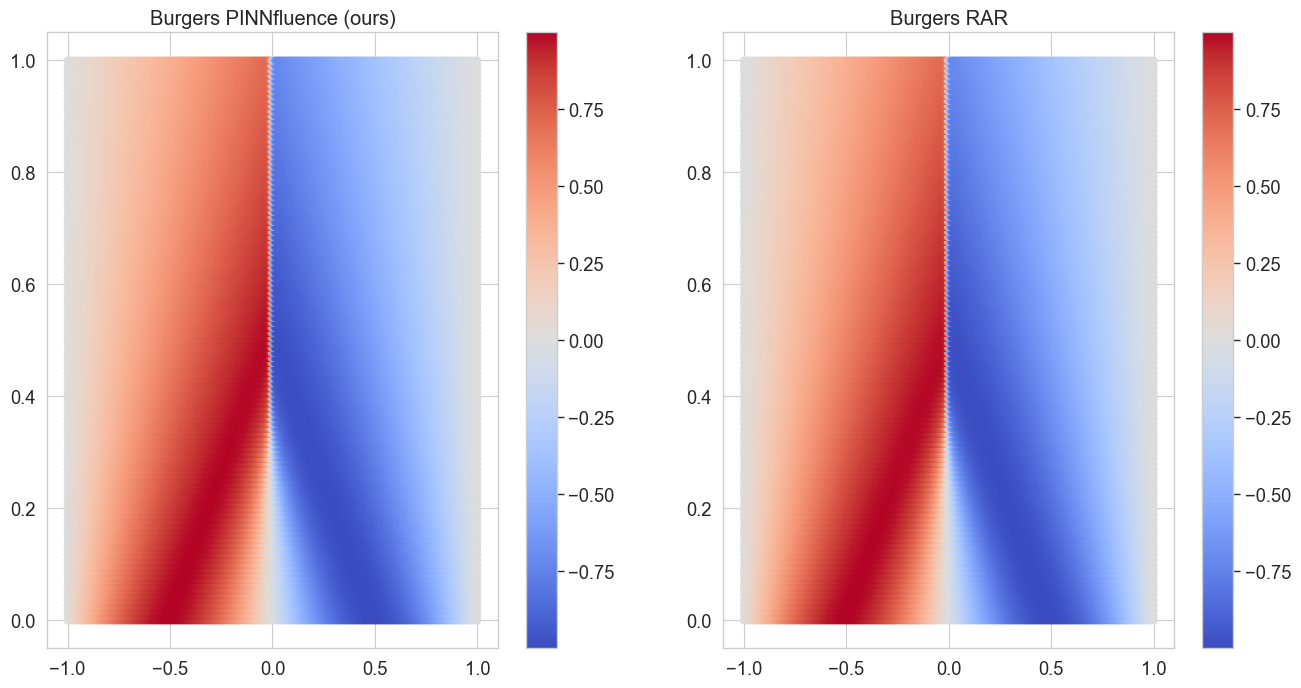

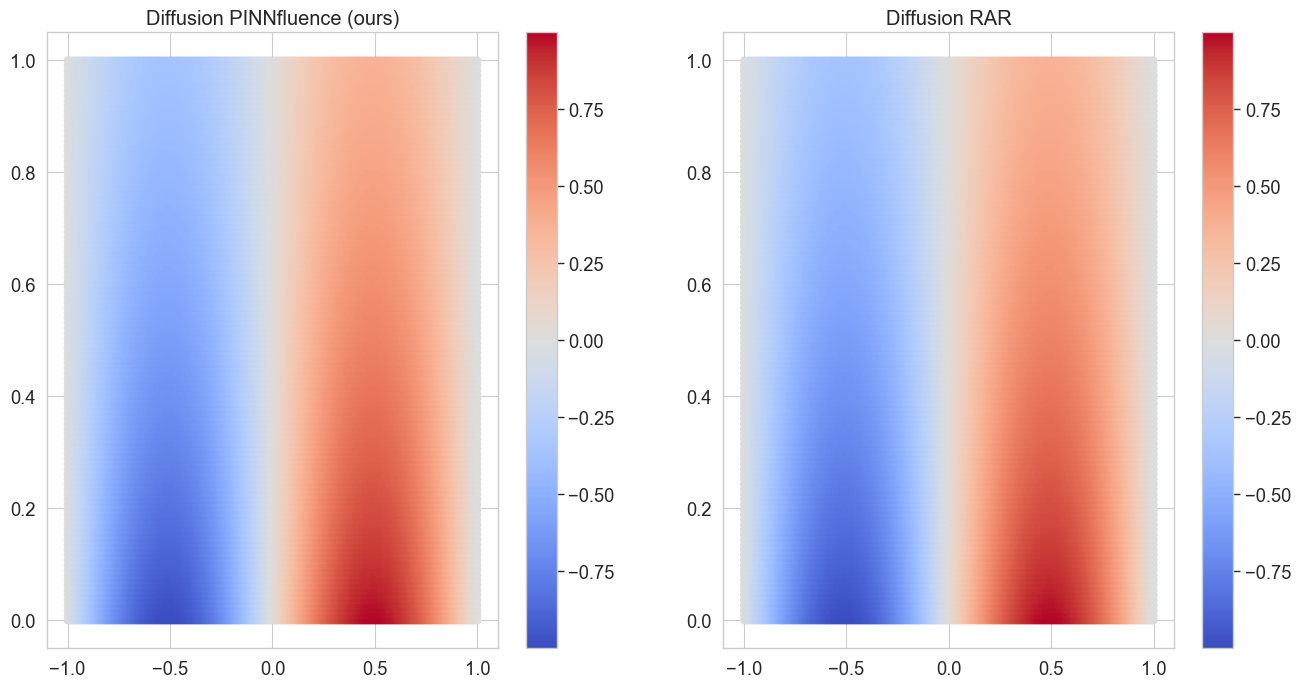

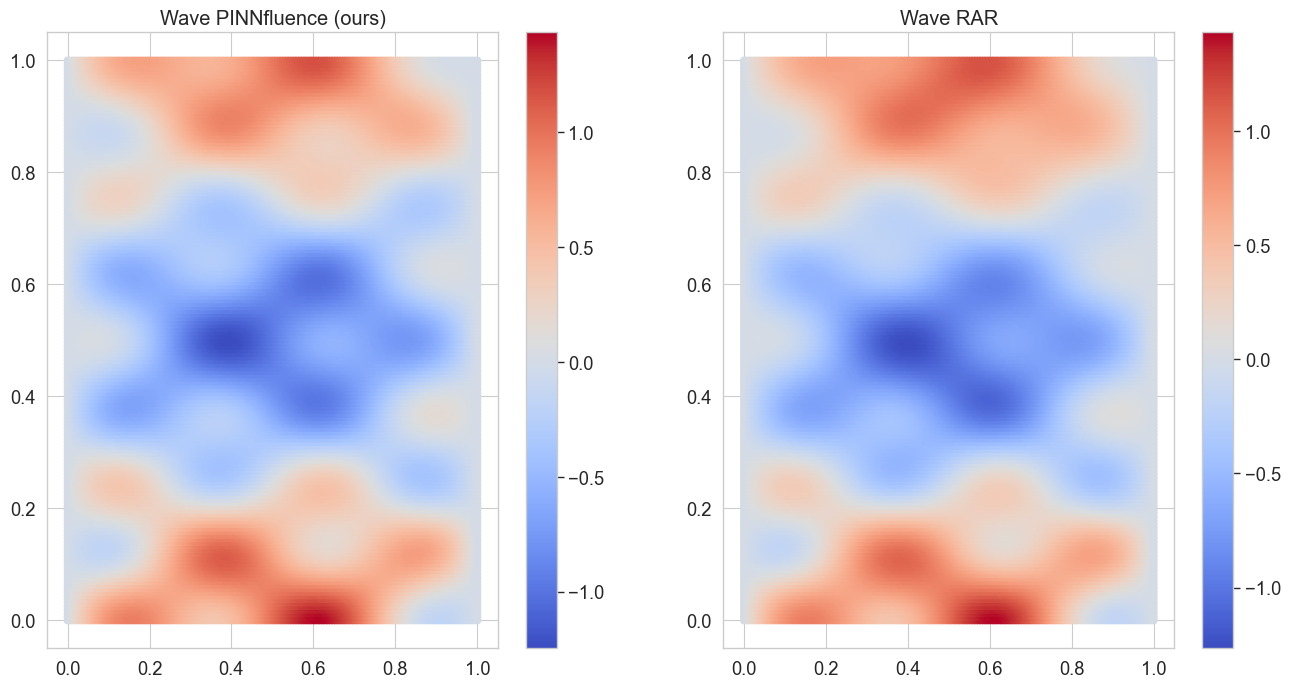

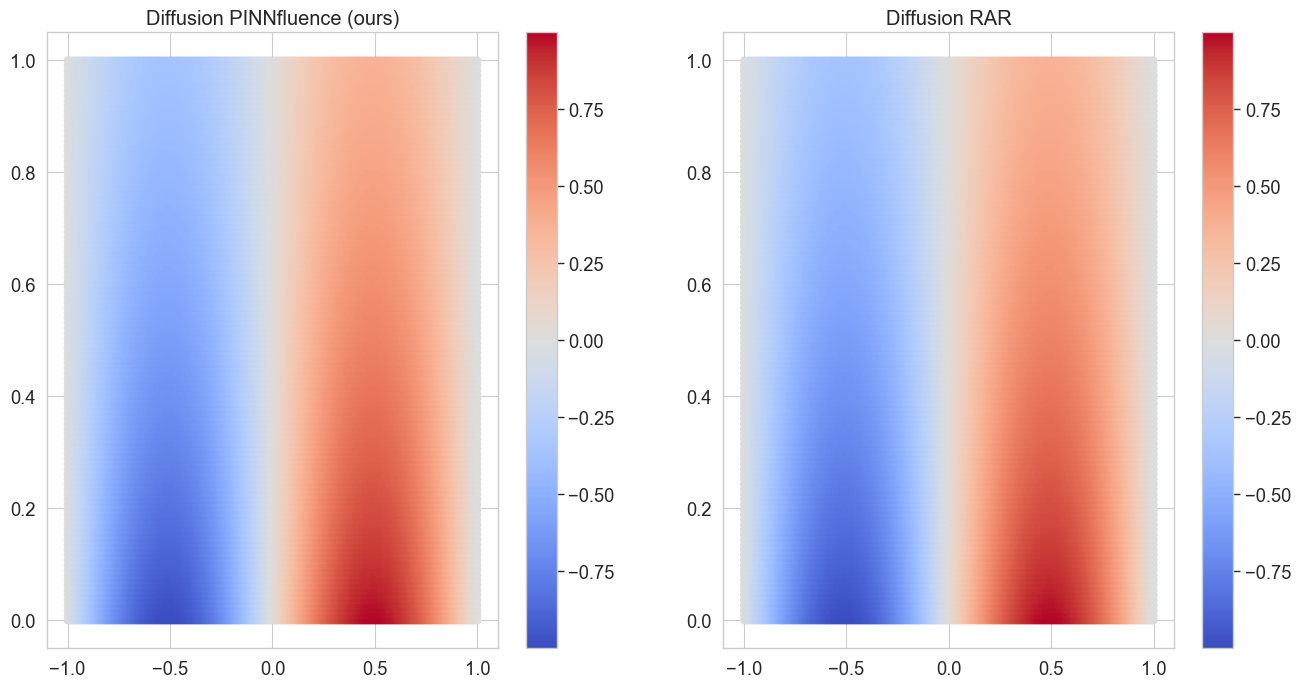

In [13]:
from pinnfluence_resampling.problem_factory import construct_problem, load_checkpoint

layers = { 
    "allen_cahn": [2] + [64] * 3 + [1],
    "burgers": [2] + [32] * 3 + [1],
    "diffusion": [2] + [32] * 3 + [1],
    "wave": [2] + [100] * 5 + [1],
}

for problem in ['burgers', 'diffusion', 'wave', 'diffusion']:
    df = load_problem(problem, results)

    print(problem)
    layers_str = f"{len(layers[problem]) - 2}_x_{layers[problem][1]}"
    sub_df = df.loc[
        (df['sampling_strategy'] == 'distribution') & 
        (df['sign'] == 'abs') & 
        (df['Iteration'] == 100000) & 
        (df['n_iter_pretrain'] == 0) & 
        (df['distribution_k'] == 1) & 
        (df['distribution_c'] == 1) & 
        (df['model_name'].str.contains(layers_str)) &
        (df['seed'] <= 10) & 
        (~df['checkpoint'].isnull()) 
    ]

    if problem == 'wave':
        sub_df = sub_df.loc[sub_df['n_samples'] == 1000]

    fig, ax = plt.subplots(ncols = 2, figsize=(16, 8))

    X = None 
    for e, strat in enumerate(['PINNfluence (ours)', 'RAR']):
        subsub_df = sub_df.loc[sub_df['Strategy'] == strat]

        preds = [] 

        for seed in subsub_df['seed'].unique():
            cur_vals = subsub_df.loc[subsub_df['seed'] == seed].iloc[-1]
            
            model, data, _, _ = construct_problem(
                problem_name = problem,
                layers = layers[problem],
                seed = seed
            )

            model.net = load_checkpoint(model.net, cur_vals['checkpoint'])
            model.net.eval()

            if X is None:
                X = data.geom.uniform_points(25_000)
            
            pred = model.predict(X)
            preds.append(pred)

        preds = np.array(preds)
        mean = np.mean(preds, axis=0)

        sc = ax[e].scatter(X[:, 0], X[:, 1], c=mean, cmap='coolwarm')
        fig.colorbar(sc, ax=ax[e])
        ax[e].set_title(f"{problem.title()} {strat}")

    fig.show()
    fig.savefig(f"figures/{problem}_preds.png")
        
